# Integrating unpaired multimodal single cell data in a shared latent space: gene imputation in mouse cortex scRNA and smFISH

Given two single-cell datasets profiled with different modalities scConfluence can map each in low-dimensional latent space shared by both modalities where distances between cell embeddings depends only on their biological similarity. These latent embeddings can then be leveraged to impute features across modalities. We show here an example of integration on a scRNA dataset with an smFISH dataset both from the mouse somatosensory cortex.

## Imports

Of note, `scikit-misc` should be installed (can be done with pip) for this notebook to be executed.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.spatial.distance import cdist
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import torch
torch.manual_seed(1792)

import scconfluence

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

You can download the unpaired multimodal dataset for this tutorial from https://figshare.com/s/72e156d0f131f8a3c810. 

In [2]:
mdata = mu.read_h5mu("RNA_smFISH_demo.h5mu.gz")
mdata

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 7535 × 20005
  obs:	'celltype', 'modality'
  2 modalities
    fish:	4530 x 33
      obs:	'x_coord', 'y_coord'
    rna:	3005 x 19972

## Perform basic quality control

We can use scanpy functions to filter out cells or features with low quality measurements.

In [3]:
sc.pp.filter_cells(mdata["rna"], min_genes=10)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["fish"], min_genes=5)
sc.pp.filter_genes(mdata["fish"], min_cells=20)
mdata.update()
mdata

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/mudata/_core/mudata.py:491: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(


MuData object with n_obs × n_vars = 7528 × 15254
  obs:	'celltype', 'modality'
  2 modalities
    fish:	4523 x 33
      obs:	'x_coord', 'y_coord', 'n_genes'
      var:	'n_cells'
    rna:	3005 x 15221
      obs:	'n_genes'
      var:	'n_cells'

## Hold out gene for imputation

To demonstrate scConfluence's ability to impute feature expression across modalities we will hide from the smFISH data the expression of a gene which was measured in the smFISH experiment, then impute it using scConfluence and compare its imputation to its held out ground truth value.

In [4]:
imputed_gene = "Sox10"

In [5]:
assert imputed_gene in mdata["rna"].var_names and imputed_gene in mdata["fish"].var_names

heldout_counts = mdata["fish"][:, imputed_gene].X.copy()
mdata.mod["fish"] = mdata["fish"][:, [g for g in mdata["fish"].var_names if g != imputed_gene]].copy()
mdata

MuData object with n_obs × n_vars = 7528 × 15254
  obs:	'celltype', 'modality'
  2 modalities
    fish:	4523 x 32
      obs:	'x_coord', 'y_coord', 'n_genes'
      var:	'n_cells'
    rna:	3005 x 15221
      obs:	'n_genes'
      var:	'n_cells'

## Preprocess common features and obtain cross-modality distance matrix

Diagonal integration, i.e. single cell multimodal unpaired integration, is a very challenging task as it aims at aligning cells in which different features were measured. To guide the alignment, we need to leverage prior biological knowledge to obtain a set of common features across modalities which will serve as a bridge for the integration. For scRNA-smFISH integration, those common features the genes that have been measured in both experiments. Once those common feature representations have been obtained, we can derive a distance matrix whose rows correspond to cells in the RNA modality and columns correspond to the cells in the FISH modality which will be used by scConfluence.

In [6]:
cm_genes = list(set(mdata["rna"].var_names) & set(mdata["fish"].var_names))
cm_features_rna = mdata["rna"][:, cm_genes].copy() 
cm_features_fish = mdata["fish"][:, cm_genes].copy() 

To preprocess the smFISH counts, we use the same normalization technique as the authors of the dataset.

In [7]:
def normalize_fish(array, col_factor=None):
    array = array / array.sum(axis=1, keepdims=True)  # Corrected for total molecules per gene
    if col_factor is None:
        col_factor = array.mean(axis=0, keepdims=True)
    array = array / col_factor  # * array.shape[1]
    return array

In [8]:
sc.pp.normalize_total(cm_features_rna, target_sum=1000.)
sc.pp.log1p(cm_features_rna)
cm_features_fish.X = normalize_fish(cm_features_fish.X)

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


In [9]:
mdata.uns["cross_rna+fish"] = cdist(cm_features_rna.X, cm_features_fish.X)
mdata.uns["cross_keys"] = ["cross_rna+fish"]

## Preprocess each modality

While the computation of the distance matrix only involved genes that were present both in the scRNA modality and the smFISH, our method leverages the original features of each modalities (i.e. all genes for the scRNA) to perform dimension reductions. 

In [10]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()

sc.pp.normalize_total(mdata["rna"], target_sum=10000.)
sc.pp.log1p(mdata["rna"])

# Since we use both raw and normalized gene counts it makes sense to select highly variable genes based on both
raw_hvg = sc.pp.highly_variable_genes(mdata["rna"], layer="counts", n_top_genes=3000, subset=False, inplace=False, 
                                     flavor="seurat_v3")["highly_variable"].values
norm_hvg = sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=3000, subset=False, 
                                       inplace=False)["highly_variable"].values
mdata.mod["rna"] = mdata["rna"][:, np.logical_or(raw_hvg, norm_hvg)].copy()
sc.tl.pca(mdata["rna"], n_comps=100, zero_center=None)

In [11]:
mdata.mod["fish"].X = normalize_fish(mdata["fish"].X)

## Define autoencoders for each modality

We define one autoencoder per modality whose aim is to extract all the biological information present in the original features while accounting for batch effects (not present here since there's only one batch) and projecting the cells to a shared latent space of low dimension (hence the dimension of the latent space `n_latent` should be the same for all autoencoders). Multiple options can be set to adapt the autoencoders to the specificity of the modalities measured, see the API documentation for details about the arguments. We here use lower `n_hidden`and `n_layers_enc` than their default values since the smFISh measurements don't contain many features.

In [12]:
autoencoders = {"rna": scconfluence.unimodal.AutoEncoder(mdata["rna"], 
                                                         modality="rna", 
                                                         rep_in="X_pca", 
                                                         rep_out="counts", 
                                                         batch_key=None,
                                                         n_hidden=64, 
                                                         n_latent=16, 
                                                         type_loss="zinb"),
                "fish": scconfluence.unimodal.AutoEncoder(mdata["fish"], 
                                                          modality="fish", 
                                                          n_layers_enc=2,
                                                          rep_in=None, 
                                                          rep_out=None, 
                                                          batch_key=None,
                                                          n_hidden=25, 
                                                          n_latent=16, 
                                                          type_loss="l2")}

## Create and train the model

The scConfluence model leverages the distance matrix stored in `mdata` to align the latent embeddings learned by autoencoders from each modality. We used here the default parameters except for `iot_loss_weight` and `reach`. Indeed, here since the gene to gene connections which allow us to compute the cross-modality distance matrix are extremely reliable, we can increase the importance of the alignment term in the total loss. Increasing `reach`allow us to enforce an even tighter mixing of the modalities in the latent space, which is necessary for successful imputation. See the API's documention for details on this. While the maximum over of epochs is set to 1000, we use earlystopping to interrupt the training when the loss has converged on validation samples which generally happens long before the upper limit of 1000 epochs. With a GPU, this training is expected to take less than 5 minutes.

In [13]:
%%time
model = scconfluence.model.ScConfluence(mdata=mdata, unimodal_aes=autoencoders, 
                                        mass=0.5, reach=1., iot_loss_weight=0.05, sinkhorn_loss_weight=0.1)
model.fit(save_path="demo_rna_fish", use_cuda=True, max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /pasteur/appa/homes/jsamaran/scConfluence/demo_rna_fish exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | aes  | ModuleDict | 812 K 
------------------------------------
812 K     Trainable params
0         Non-trainable params
812 K     To

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|█████████████████████████| 12/12 [00:00<00:00, 18.79it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████| 12/12 [00:00<00:00, 23.88it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████| 12/12 [00:00<00:00, 23.93it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████| 12/12 [00:00<00:00, 24.11it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████████| 12/12 [00:00<00:00, 23.64it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████████| 12/12 [00:00<00:00, 24.19it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

Epoch 28: 100%|████████████████████████| 12/12 [00:00<00:00, 24.14it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|████████████████████████| 12/12 [00:00<00:00, 23.86it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|████████████████████████| 12/12 [00:00<00:00, 23.83it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 31: 100%|████████████████████████| 12/12 [00:00<00:00, 24.11it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|████████████████████████| 12/12 [00:00<00:00, 24.02it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 33: 100%|████████████████████████| 12/12 [00:00<00:00, 23.90it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|█████████████

Epoch 56: 100%|████████████████████████| 12/12 [00:00<00:00, 23.79it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 57: 100%|████████████████████████| 12/12 [00:00<00:00, 23.85it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|████████████████████████| 12/12 [00:00<00:00, 24.00it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|████████████████████████| 12/12 [00:00<00:00, 24.16it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 60: 100%|████████████████████████| 12/12 [00:00<00:00, 23.93it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 61: 100%|████████████████████████| 12/12 [00:00<00:00, 24.24it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 62: 100%|█████████████

Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 84: 100%|████████████████████████| 12/12 [00:00<00:00, 24.10it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 85: 100%|████████████████████████| 12/12 [00:00<00:00, 24.16it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 86: 100%|████████████████████████| 12/12 [00:00<00:00, 24.26it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 87: 100%|████████████████████████| 12/12 [00:00<00:00, 24.06it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 88: 100%|████████████████████████| 12/12 [00:00<00:00, 24.18it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 89: 100%|████████████████████████| 12/12 [00:00<00:00, 23.74it/s, v_num=3]
Validation: |               

Epoch 111: 100%|███████████████████████| 12/12 [00:00<00:00, 23.73it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 112: 100%|███████████████████████| 12/12 [00:00<00:00, 23.83it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 113: 100%|███████████████████████| 12/12 [00:00<00:00, 23.64it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 114: 100%|███████████████████████| 12/12 [00:00<00:00, 23.97it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 115: 100%|███████████████████████| 12/12 [00:00<00:00, 23.79it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 116: 100%|███████████████████████| 12/12 [00:00<00:00, 23.01it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 117: 100%|████████████

Epoch 139: 100%|███████████████████████| 12/12 [00:00<00:00, 23.98it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 140: 100%|███████████████████████| 12/12 [00:00<00:00, 23.63it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 141: 100%|███████████████████████| 12/12 [00:00<00:00, 21.40it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 142: 100%|███████████████████████| 12/12 [00:00<00:00, 23.69it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 143: 100%|███████████████████████| 12/12 [00:00<00:00, 23.77it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 144: 100%|███████████████████████| 12/12 [00:00<00:00, 23.96it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 145: 100%|████████████

Epoch 167: 100%|███████████████████████| 12/12 [00:00<00:00, 23.80it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 168: 100%|███████████████████████| 12/12 [00:00<00:00, 23.85it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 169: 100%|███████████████████████| 12/12 [00:00<00:00, 23.84it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 170: 100%|███████████████████████| 12/12 [00:00<00:00, 23.81it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 171: 100%|███████████████████████| 12/12 [00:00<00:00, 23.66it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 172: 100%|███████████████████████| 12/12 [00:00<00:00, 24.04it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 173: 100%|████████████

Epoch 194: 100%|███████████████████████| 12/12 [00:00<00:00, 24.10it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 195: 100%|███████████████████████| 12/12 [00:00<00:00, 23.58it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 196: 100%|███████████████████████| 12/12 [00:00<00:00, 24.08it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 197: 100%|███████████████████████| 12/12 [00:00<00:00, 24.00it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 198: 100%|███████████████████████| 12/12 [00:00<00:00, 23.70it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|███████████████████████| 12/12 [00:00<00:00, 24.09it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 200: 100%|████████████

Epoch 222: 100%|███████████████████████| 12/12 [00:00<00:00, 24.04it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 223: 100%|███████████████████████| 12/12 [00:00<00:00, 24.08it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 224: 100%|███████████████████████| 12/12 [00:00<00:00, 23.92it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 225: 100%|███████████████████████| 12/12 [00:00<00:00, 23.89it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 226: 100%|███████████████████████| 12/12 [00:00<00:00, 24.10it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 227: 100%|███████████████████████| 12/12 [00:00<00:00, 23.61it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 228: 100%|████████████

Epoch 250: 100%|███████████████████████| 12/12 [00:00<00:00, 24.09it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 251: 100%|███████████████████████| 12/12 [00:00<00:00, 23.93it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 252: 100%|███████████████████████| 12/12 [00:00<00:00, 23.62it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 253: 100%|███████████████████████| 12/12 [00:00<00:00, 23.97it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 254: 100%|███████████████████████| 12/12 [00:00<00:00, 23.77it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 255: 100%|███████████████████████| 12/12 [00:00<00:00, 24.01it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 256: 100%|████████████

Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 278: 100%|███████████████████████| 12/12 [00:00<00:00, 24.16it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 279: 100%|███████████████████████| 12/12 [00:00<00:00, 23.81it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 280: 100%|███████████████████████| 12/12 [00:00<00:00, 24.09it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 281: 100%|███████████████████████| 12/12 [00:00<00:00, 24.25it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 282: 100%|███████████████████████| 12/12 [00:00<00:00, 23.90it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 283: 100%|███████████████████████| 12/12 [00:00<00:00, 23.98it/s, v_num=3]
Validation: |               

Epoch 305: 100%|███████████████████████| 12/12 [00:00<00:00, 24.06it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 306: 100%|███████████████████████| 12/12 [00:00<00:00, 24.04it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 307: 100%|███████████████████████| 12/12 [00:00<00:00, 23.92it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 308: 100%|███████████████████████| 12/12 [00:00<00:00, 23.45it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 309: 100%|███████████████████████| 12/12 [00:00<00:00, 24.33it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 310: 100%|███████████████████████| 12/12 [00:00<00:00, 24.06it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 311: 100%|████████████

Epoch 333: 100%|███████████████████████| 12/12 [00:00<00:00, 23.84it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 334: 100%|███████████████████████| 12/12 [00:00<00:00, 24.04it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 335: 100%|███████████████████████| 12/12 [00:00<00:00, 24.34it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 336: 100%|███████████████████████| 12/12 [00:00<00:00, 24.06it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 337: 100%|███████████████████████| 12/12 [00:00<00:00, 23.34it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 338: 100%|███████████████████████| 12/12 [00:00<00:00, 24.05it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 339: 100%|████████████

Epoch 361: 100%|███████████████████████| 12/12 [00:00<00:00, 24.40it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 362: 100%|███████████████████████| 12/12 [00:00<00:00, 24.14it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 363: 100%|███████████████████████| 12/12 [00:00<00:00, 24.42it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 364: 100%|███████████████████████| 12/12 [00:00<00:00, 23.99it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 365: 100%|███████████████████████| 12/12 [00:00<00:00, 24.17it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 366: 100%|███████████████████████| 12/12 [00:00<00:00, 24.14it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 367: 100%|████████████

Epoch 388: 100%|███████████████████████| 12/12 [00:00<00:00, 24.39it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 389: 100%|███████████████████████| 12/12 [00:00<00:00, 24.30it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 390: 100%|███████████████████████| 12/12 [00:00<00:00, 24.11it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 391: 100%|███████████████████████| 12/12 [00:00<00:00, 24.12it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 392: 100%|███████████████████████| 12/12 [00:00<00:00, 24.24it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 393: 100%|███████████████████████| 12/12 [00:00<00:00, 24.33it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 394: 100%|████████████

Epoch 416: 100%|███████████████████████| 12/12 [00:00<00:00, 24.22it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 417: 100%|███████████████████████| 12/12 [00:00<00:00, 24.03it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 418: 100%|███████████████████████| 12/12 [00:00<00:00, 24.46it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 419: 100%|███████████████████████| 12/12 [00:00<00:00, 24.37it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 420: 100%|███████████████████████| 12/12 [00:00<00:00, 24.14it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 421: 100%|███████████████████████| 12/12 [00:00<00:00, 24.28it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 422: 100%|████████████

Epoch 444: 100%|███████████████████████| 12/12 [00:00<00:00, 24.26it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 445: 100%|███████████████████████| 12/12 [00:00<00:00, 24.31it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 446: 100%|███████████████████████| 12/12 [00:00<00:00, 23.92it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 447: 100%|███████████████████████| 12/12 [00:00<00:00, 24.38it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 448: 100%|███████████████████████| 12/12 [00:00<00:00, 24.35it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 449: 100%|███████████████████████| 12/12 [00:00<00:00, 24.20it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 450: 100%|████████████

Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 472: 100%|███████████████████████| 12/12 [00:00<00:00, 24.43it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 473: 100%|███████████████████████| 12/12 [00:00<00:00, 24.16it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 474: 100%|███████████████████████| 12/12 [00:00<00:00, 24.41it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 475: 100%|███████████████████████| 12/12 [00:00<00:00, 24.44it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 476: 100%|███████████████████████| 12/12 [00:00<00:00, 24.40it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 477: 100%|███████████████████████| 12/12 [00:00<00:00, 24.12it/s, v_num=3]
Validation: |               

Epoch 498: 100%|███████████████████████| 12/12 [00:00<00:00, 19.05it/s, v_num=3]
CPU times: user 4min 51s, sys: 5.38 s, total: 4min 57s
Wall time: 5min 27s


## Obtaining and visualizing latent embeddings of all cells

In [14]:
mdata.obsm["latent"] = model.get_latent(use_cuda=True).loc[mdata.obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████████████| 15/15 [00:00<00:00, 81.16it/s]


While conclusions should not be drawn from UMAP plots we use it here to visualize the results of the integration.

/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/scConfluence/venvs/conf/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


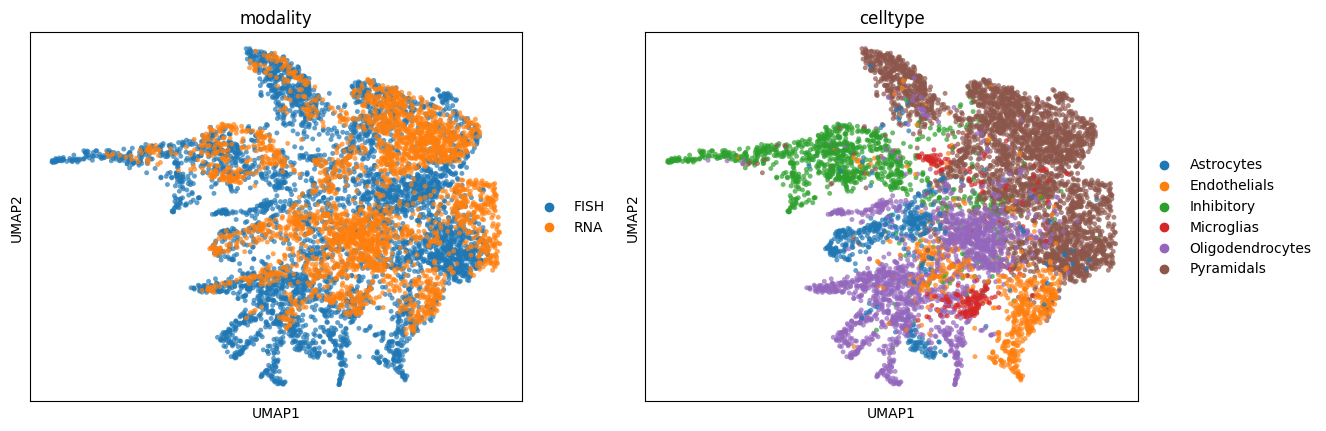

In [15]:
sc.pp.neighbors(mdata, use_rep="latent", key_added="scConfluence")
sc.tl.umap(mdata, neighbors_key="scConfluence")
sc.pl.umap(mdata, color=["modality", "celltype"], size=50, alpha=0.7)

## Imputing heldout measurements

Now that the model has been trained, we can use the RNA decoder to predict gene expression measurements from the smFISH latent embeddings.

In [16]:
imputed_gene_idx = list(mdata["rna"].var_names).index(imputed_gene)
mdata["fish"].obs[f"imputed_{imputed_gene}"] = model.get_imputation(use_cuda=True, 
                                                                    impute_from="fish", 
                                                                    impute_to="rna").iloc[:, imputed_gene_idx].loc[mdata["fish"].obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|████████████████████| 9/9 [00:00<00:00, 99.79it/s]


Since smFISH measurements come with 2D positions of the cells which were profiled, we can compare visually the spatial patterns of expression of the ground-truth and imputed expressions of the heldout gene.

In [17]:
def plot_spatial_expression(ax, x_coord, y_coord, values, title, s=20):
    def order_by_strenght(x, y, z):
        ind = np.argsort(z)
        return x[ind], y[ind], z[ind]
    x, y, z = order_by_strenght(x_coord, y_coord, values)
    c = np.arange(len(z)) / len(z)
    ax.scatter(x, y, c=c, s=s, edgecolors="none", rasterized=True)#, marker="s")  # , cmap="Reds")
    ax.axis('scaled')
    ax.axis("off")
    ax.set_title(title)

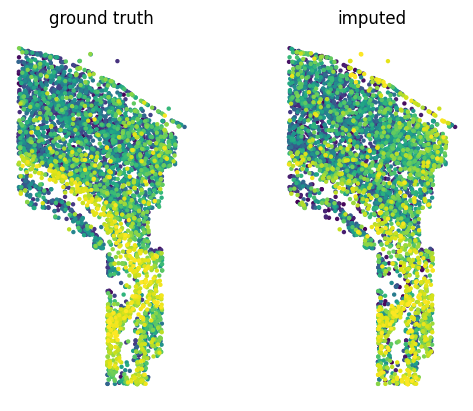

In [18]:
fig, (ax_gt, ax_imp) = plt.subplots(1, 2)
plot_spatial_expression(ax=ax_gt, x_coord=mdata["fish"].obs["x_coord"].values, 
                        y_coord=mdata["fish"].obs["y_coord"].values,
                        values=heldout_counts.reshape(-1), 
                        title="ground truth", 
                        s=10)
plot_spatial_expression(ax=ax_imp, x_coord=mdata["fish"].obs["x_coord"].values, 
                        y_coord=mdata["fish"].obs["y_coord"].values,
                        values=mdata["fish"].obs[f"imputed_{imputed_gene}"].values.reshape(-1), 
                        title="imputed", 
                        s=10)